### Common Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Task 1 - Identify Features

- **Assemble a dataset consisting of features and target:**

In [2]:
# Read in all vehicle data
vehicle_data = pd.read_csv('./vehicles.csv')

In [3]:
# Print basic info
data_shape = vehicle_data.shape
print(f'Data has {data_shape[0]:,} rows and {data_shape[1]} columns')

Data has 509,577 rows and 25 columns


In [4]:
# Separate data into raw features and target
target_col = 'price'
raw_features = vehicle_data.drop(columns=target_col)
raw_target = vehicle_data.price

- **What features are relevant for the prediction task?**

Certainly features that are entirely **empty** cannot be informative:

In [5]:
empty_features = raw_features.columns[raw_features.isna().all()].to_list()
print('Entirely empty features:', empty_features)

Entirely empty features: ['county']


Based purely on the **column descriptions**, some features will likely be irrelevant to predict price.  
**Note**: we may end up extracting new features from some of these dropped columns later on.

In [6]:
irrelevant_features = ['url', 'vin', 'image_url']

To get a sense of how relevant the remaining features may be to predict price, we can visualize their relationship to the target value:

In [7]:
relevant_features = raw_features.columns.difference(empty_features+irrelevant_features, sort=False)
relevant_types = raw_features.dtypes[relevant_features]

##### Continuous features

In [8]:
cont_feats = relevant_features[relevant_types != 'object']

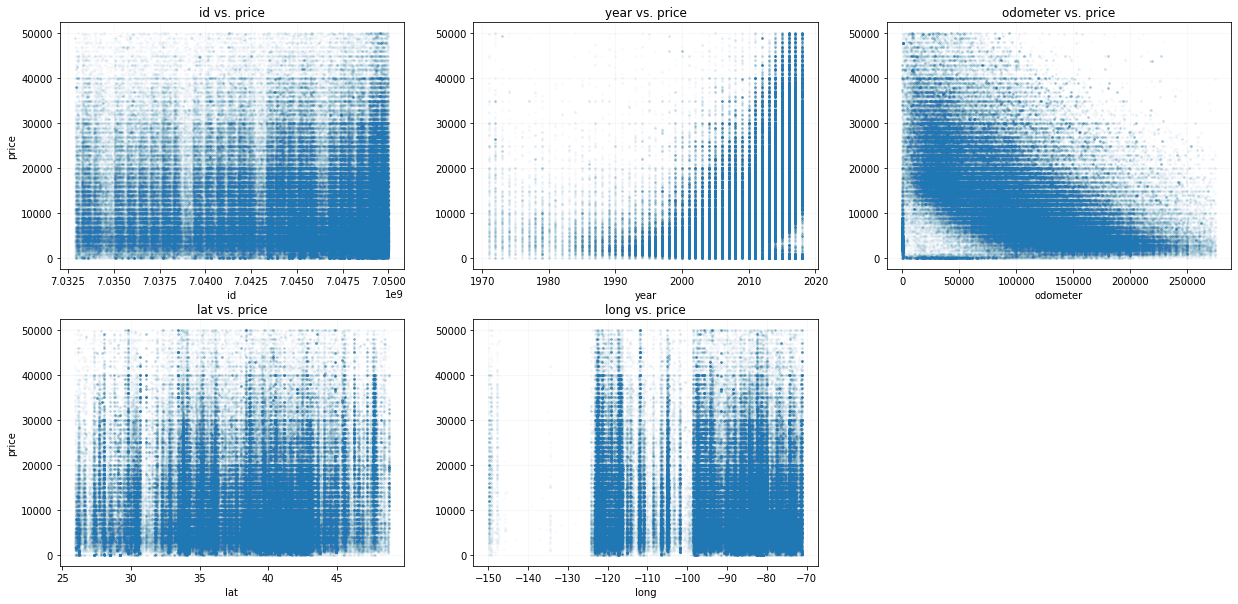

In [9]:
# Figure out an appropriate number of rows and columns
num_cont_feats = len(cont_feats)
plot_cols = 3
plot_rows = math.ceil(num_cont_feats / plot_cols)

# Restrict visualizations to positive prices within 99th percentile
# so that outliers don't distort the scale of the y-axis
price_rows = (raw_target > 0) & (raw_target < raw_target.quantile(.99))

# For each continuous feature...
fig, axs = plt.subplots(plot_rows, plot_cols, figsize=(7*plot_cols, 5*plot_rows))
for i, feature in enumerate(cont_feats):
    # Get the axes for this feature
    row=i//plot_cols
    col=i%plot_cols
    ax=axs[row,col]
    
    # Decide which rows to plot for this feature
    # To avoid outliers distorting the scale of the x-axis, we'll ignore data below the 1st percentile
    # or above the 99th percentile.
    feature_col = raw_features[feature]
    feature_rows = (feature_col > feature_col.quantile(.01)) & (feature_col < feature_col.quantile(.99))
    rows_to_plot = price_rows & feature_rows
    
    # Create a scatter plot for this feature vs. target
    ax.scatter(feature_col[rows_to_plot], raw_target[rows_to_plot], s=3, alpha=0.02)
    ax.grid(alpha=0.1)
    ax.set_axisbelow(True)
    
    # Label the plot
    ax.set_title(feature+' vs. price')
    ax.set_xlabel(feature)
    if col==0:
        ax.set_ylabel('price')
        
# Hide any axis we didn't use
num_axes_to_hide = plot_rows*plot_cols - num_cont_feats
for i in range(num_axes_to_hide):
    axs.flatten()[-(i+1)].set_axis_off()

From these plots, we conclude the following:
- both 'year' and 'odometer' have strong correlations with 'price' (although in opposite directions)
- 'id' may have a weak positive correlation with 'price'.
- 'lat' and 'long' by themselves do not appear to have a specific relationship to 'price'.  These may require more advanced feature engineering to extract predictive information.

In [10]:
uninformative_features = ['lat', 'long']

##### Discrete features

In [11]:
# TODO

##### Categorical features

In [12]:
# TODO
dirty_features = ['model']

- **Are there any features that should be excluded because they leak the target information?**

We noticed that the '**description**' column could possibly leak some target information, as it occassionally contains pricing information.  
For example, the following are excerpts from entries in the 'description' column, along with the actual target value:  
- "...I am asking $39,500 for this awesome truck..." (price=39,500)

- "...asking $1000 or best offer..." (price=1,000)

- "...asking $23400 or best offer..." (price=23,400)

In [13]:
leaky_features = ['description']

#### Region analysis
In examining the data, we noticed that the '**region**' column might not be specific enough to identify the actual region of the vehicle due to the same city name existing in multiple states.  We see evidence of this when comparing the 'region' column to the '**region_url**' column, which appears to make more distinctions.  The following are a few examples of where 'region' is duplicated:

| **region** | **region_url**                      |
|------------|-------------------------------------|
| albany     | https://albany.craigslist.org       |
| albany     | https://albanyga.craigslist.org     |
| athens     | https://athensga.craigslist.org     |
| athens     | https://athensohio.craigslist.org   |
| charleston | https://charleston.craigslist.org   |
| charleston | https://charlestonwv.craigslist.org |
| columbus   | https://columbus.craigslist.org     |
| columbus   | https://columbusga.craigslist.org   |

As '**region_url**' is a more specific version of the '**region**' feature and more accurately defines the true location of the vehicle, we're going to drop the 'region' feature and use only 'region_url'.

In [14]:
unspecific_features = ['region']

#### Conclusions

From the above analyses, we're going to **drop** the following features for our baseline model:
- 'county' (entirely empty)
- 'url' (irrelevant as is, but we may extract features from it in subsequent steps)
- 'image_url' and 'vin' (irrelevant)
- 'lat' and 'long' (requires feature engineering to be informative)
- 'description' (could leak target information, but we may extract features from it in subsequent steps)
- 'region' ('region_url' is more accurate)
- 'model' (requires extensive cleanup before it will be useful)

In [15]:
features_to_drop = empty_features + irrelevant_features + uninformative_features + leaky_features + unspecific_features + dirty_features
print('Features to drop for Baseline model:', features_to_drop)

Features to drop for Baseline model: ['county', 'url', 'vin', 'image_url', 'lat', 'long', 'description', 'region', 'model']


## Task 2 - Preprocessing and Baseline Model

- **Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model.**

In [16]:
baseline_features = raw_features.columns.difference(features_to_drop, sort=False)
baseline_features

Index(['id', 'region_url', 'year', 'manufacturer', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size',
       'type', 'paint_color', 'state'],
      dtype='object')

#### Prepare baseline preprocessing

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
import category_encoders as ce

# Define orderings for discrete features we'll encode with OrdinalEncoder
condition_cats = ['salvage', 'fair', 'missing_value', 'good', 'excellent', 'like new', 'new']
cylinder_cats = ['3 cylinders', '4 cylinders', 'missing_value', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders', 'other']
size_cats = ['sub-compact', 'compact', 'missing_value', 'mid-size', 'full-size']

# Define a function to cap odometer values to 500,000
def cap_odometer(x):
    return x.mask(x>500000, 500000)

# Prepare transformation pipelines for different column types
target_encode_pl = make_pipeline(ce.TargetEncoder(), StandardScaler())
median_scale_pl = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
new_cat_ohe_pl = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder(handle_unknown='ignore'))
new_cat_ord_enc_scale_pl = make_pipeline(SimpleImputer(strategy='constant'), OrdinalEncoder(categories=[condition_cats, cylinder_cats, size_cats]), StandardScaler())
most_freq_ohe_pl = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))
cap_median_scale_pl = make_pipeline(FunctionTransformer(cap_odometer), SimpleImputer(strategy='median'), StandardScaler())

# Contruct our baseline preprocessing transformation
baseline_preprocessor = make_column_transformer(
    (StandardScaler(), ['id']),
    (target_encode_pl, ['region_url']),
    (median_scale_pl, ['year']),
    (new_cat_ohe_pl, ['manufacturer', 'drive', 'type', 'paint_color', 'state']),
    (new_cat_ord_enc_scale_pl, ['condition', 'cylinders', 'size']),
    (most_freq_ohe_pl, ['fuel', 'title_status', 'transmission']),
    (cap_median_scale_pl, ['odometer']))

- **You don't need to validate the model on the whole dataset.**

In [18]:
# Drop rows from the raw data that we think are invalid...
valid_rows = (raw_target > 0) & (raw_target < raw_target.quantile(.99))
# TODO: Drop rows missing many features???

In [19]:
# Subsample the data for training a baseline model
from sklearn.model_selection import train_test_split

X = raw_features.loc[valid_rows, baseline_features]
y = raw_target[valid_rows]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, train_size=0.25, random_state=25)
X_train.shape

(115223, 15)

In [20]:
# Testing of column transformer (remove once the baseline model is written)
transformed_X = baseline_preprocessor.fit_transform(X_train, y_train)
transformed_X.shape

(115223, 145)

**TODO:**  
Try a LINEAR model (ridge, lasso, elasticnet, or lin. regression)  
Come up with a baseline score